# Fluctuating Intensities
## Read files from OMERO and analyse fluctuations of pixel intensities
Laura Cooper 19/05/2020

## Prerequisite
### Import Packages

In [60]:
from omero.gateway import BlitzGateway
import getpass
import numpy as np
from scipy import fft, ndimage
import matplotlib.pyplot as plt

### Define functions

#### Convert image stack to np.array

In [3]:
def get_z_stack(img, c=0, t=0):
    """
    Convert OMERO image object to numpy array
    """
    zct_list = [(z, c, t) for z in range(img.getSizeZ())]
    pixels = img.getPrimaryPixels()
    return np.array(list(pixels.getPlanes(zct_list)))

#### Calculate turbulence statistics

In [4]:
def turb_stats(f, Fs):
    """
    Get turblence statistics for each pixel
    Input: f     numpy array of image
           Fs    sample frequency
    """
    L=np.shape(f)
    # mean velocity over time for every pixel
    ind_u_bar=np.mean(f, axis = 0); #mean over time
    # Reynolds decomposition to calculate turbulent fluctuations
    ind_u_fluct=np.subtract(f,ind_u_bar)
    #Turblence Strength
    ind_u_rms=np.std(ind_u_fluct, axis = 0) #standard deviation over time
    # Frequency spectrum
    ind_u_fft=fft.fft(ind_u_fluct, axis = 0) #fast fourier transform in time
    P2=abs(ind_u_fft/L[0]) #2 sided spectrum
    P1=P2[0:int(L[0]/2)]; #1 sided spectrum
    P1[1:len(P1)-1]=2*P1[1:len(P1)-1];
    fd=Fs*np.arange(0,L[0]/2,1)/L[0]; #Freqency domain
    return ind_u_bar, ind_u_rms, P1, fd

#### Calculate tubulence statistics for all images in a dataset

In [8]:
def Fluc_ds(dataset):
    u_bar = np.zeros(16)
    u_rms = np.zeros(16)
    P1_mean = np.zeros([15,16])
    fd_all = np.zeros([15,16])
    Iid = np.zeros(16, dtype=int)
    i=0;
    for image in conn.getObjects('Image', opts={'dataset': dataset}): #loop all images in data set
        Iid[i] = image.getId()
        f = get_z_stack(image)
        ind_u_bar, ind_u_rms, P1, fd = turb_stats(f, 5.6) #Assumes sample frequency same for all images
        #Average in space         
        u_bar[i]=np.mean(ind_u_bar, axis=(0,1))
        u_rms[i] = np.mean(ind_u_rms, axis=(0,1))
        P1_mean[:,i]=np.mean(P1,axis=(1,2))
        fd_all[:,i]=fd
        i=i+1
    return Iid, u_bar, u_rms, P1_mean, fd_all

## Connect to OMERO

In [2]:
username = input('Username: ') #Request user to enter OMERO username
password = getpass.getpass(prompt='Password: ') #Request user to enter OMERO password
conn = BlitzGateway(username, password, host='camdu.warwick.ac.uk', port=4064) #Use details to connect to OMERO server
conn.connect() #Returns true when connected

Username: u1675160
Password: ········


True

## Get IDs for calling objects
Here we print the IDs for groups, owners, datasets and images from OMERO. We need these to call the images we want to analyse.

First the groups and owners:

List the datasets and their images:

In [5]:
print("\nList Datasets: \n", "=" * 50)
datasets = conn.getObjects("Dataset", opts={'owner': 3})
keys=[]
values=[]
for obj in datasets:
    print("""%s%s:%s  Name:"%s" (owner=%s)""" % (
        " " * 2,
        obj.OMERO_CLASS,
        obj.getId(),
        obj.getName(),
        obj.getOwnerOmeName()
    ))
    keys.append(obj.getName())
    values.append(obj.getId())


List Datasets: 
  Dataset:8202  Name:"ER" (owner=mlsmaf)
  Dataset:8203  Name:"GFP" (owner=mlsmaf)
  Dataset:8204  Name:"INVs" (owner=mlsmaf)
  Dataset:8205  Name:"mitochondria" (owner=mlsmaf)
  Dataset:8206  Name:"plasma membrane" (owner=mlsmaf)
  Dataset:8207  Name:"recycling endosomes" (owner=mlsmaf)
  Dataset:8252  Name:"output 181114" (owner=mlsmaf)


Put dataset names in dictionary.

In [6]:
Datasets=dict(zip(keys[:-1], values[:-1]))

Set up dictionarys for results

In [7]:
ImageIDs=dict.fromkeys(keys[:-1])
Mean_Vel_Im=dict.fromkeys(keys[:-1])
TurbStreng_Im=dict.fromkeys(keys[:-1])
Amp_Im=dict.fromkeys(keys[:-1])
Freq_Im=dict.fromkeys(keys[:-1])

In [9]:
for key in Datasets:
    ImageIDs[key], Mean_Vel_Im[key], TurbStreng_Im[key], Amp_Im[key], Freq_Im[key] = Fluc_ds(Datasets[key])

Every image in stack

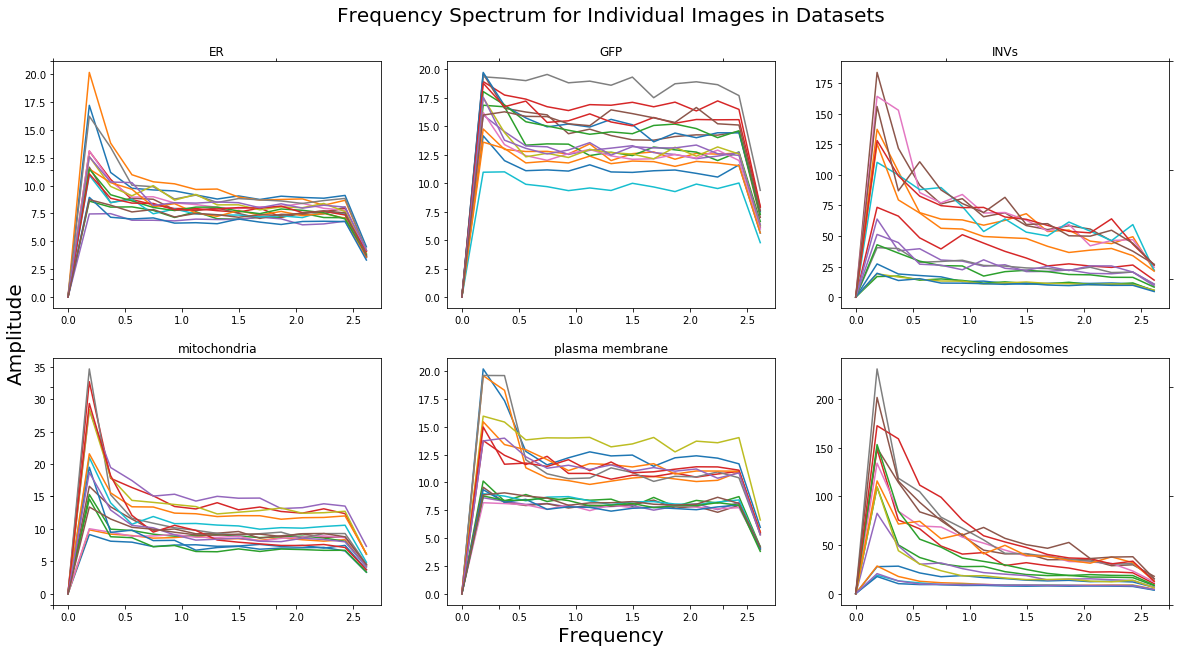

In [13]:
fig, axs = plt.subplots(2,3,figsize=(20,10))
fig.add_subplot(111, frameon=False)
for key in Datasets:
    axs[int(list(Datasets.keys()).index(key)>=3),list(Datasets.keys()).index(key)%3].plot(Freq_Im[key],Amp_Im[key])
    axs[int(list(Datasets.keys()).index(key)>=3),list(Datasets.keys()).index(key)%3].title.set_text(key)

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel("Frequency",fontsize = 20)
plt.ylabel("Amplitude",fontsize = 20)
plt.title("Frequency Spectrum for Individual Images in Datasets",fontsize = 20,pad=40)
plt.show;

Averages for datasets

In [11]:
Amp_meanDS=dict.fromkeys(keys[:-1])
Freq_meanDS=dict.fromkeys(keys[:-1])
Amp_stdDS=dict.fromkeys(keys[:-1])
Mean_Vel_DS=dict.fromkeys(keys[:-1])
TurbStreng_DS=dict.fromkeys(keys[:-1])
for key in Amp_meanDS:
    Amp_meanDS[key]=np.mean(Amp_Im[key], axis=1)
    Freq_meanDS[key]=np.mean(Freq_Im[key], axis=1)
    Amp_stdDS[key]=np.std(Amp_Im[key], axis=1)
    Mean_Vel_DS[key]=np.mean(Mean_Vel_Im[key])
    TurbStreng_DS[key]=np.mean(TurbStreng_Im[key])

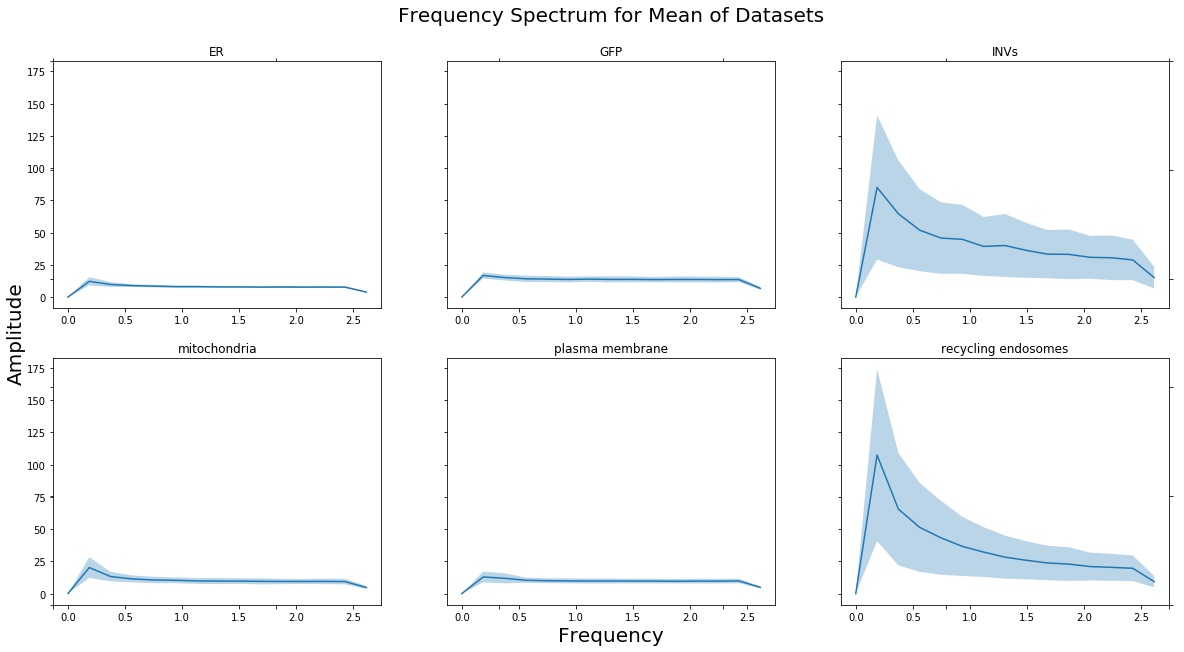

In [59]:
fig, axs = plt.subplots(2,3,figsize=(20,10),sharey=True)
fig.add_subplot(111, frameon=False)
for key in Datasets:
    #print('Mean Velocity:', Mean_Vel[key])
    #print('Turbulence Strength:', TurbStreng[key])
    axs[int(list(Datasets.keys()).index(key)>=3),list(Datasets.keys()).index(key)%3].plot(Freq_meanDS[key],Amp_meanDS[key])
    axs[int(list(Datasets.keys()).index(key)>=3),list(Datasets.keys()).index(key)%3].fill_between(Freq_meanDS[key], Amp_meanDS[key]-Amp_stdDS[key], Amp_meanDS[key]+Amp_stdDS[key] ,alpha=0.3)
    axs[int(list(Datasets.keys()).index(key)>=3),list(Datasets.keys()).index(key)%3].title.set_text(key)

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel("Frequency",fontsize = 20)
plt.ylabel("Amplitude",fontsize = 20)
plt.title("Frequency Spectrum for Mean of Datasets",fontsize = 20,pad=40)
plt.show;

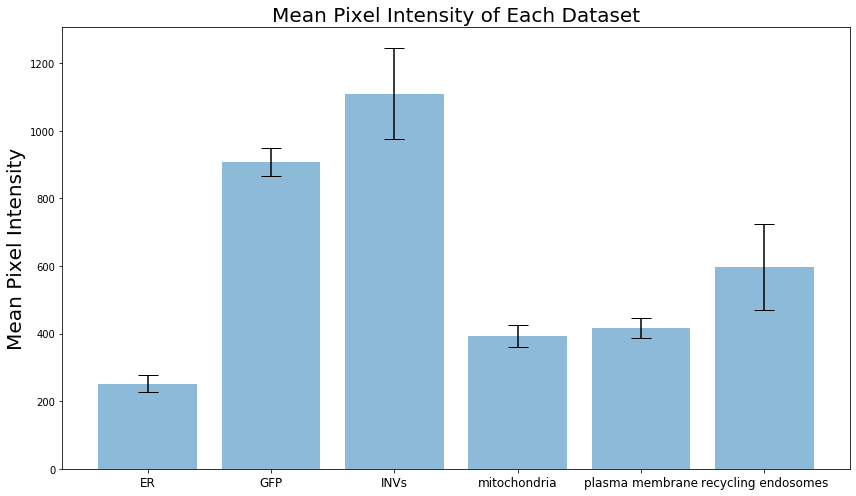

In [58]:
fig, ax = plt.subplots(figsize=(12,7))
ax.bar(np.arange(len(list(Mean_Vel_DS.values()))), list(Mean_Vel_DS.values()), yerr=list(TurbStreng_DS.values()), align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean Pixel Intensity',fontsize=20)
ax.set_xticks(np.arange(len(list(Mean_Vel_DS.values()))))
ax.set_xticklabels(Mean_Vel_DS.keys(), fontsize=12)
ax.set_title('Mean Pixel Intensity of Each Dataset',fontsize=20)
fig.tight_layout()
plt.show()